# 10 | AI 连接外部资料库，让 LlamaIndex 带你阅读一本书

## 通过 llama_index 封装“第二大脑”

我给上面的这种先搜索、后提升的方式，取了一个名字，叫做 AI 的“第二大脑”模式。因为这个方法，需要提前把你希望 AI 能够回答的知识，建立一个外部的索引，这个索引好像 AI 的“第二大脑”。每次向 AI 提问的时候，它都会先去查询一下这个第二大脑里面的资料，找到相关的资料后，再通过自己的思维能力来回答问题。

安装依赖
```
pip3 install llama-index
pip3 install langchain
```

In [10]:

import openai, os
from llama_index import GPTVectorStoreIndex, SimpleDirectoryReader

openai.api_key = os.environ.get("OPENAI_API_KEY")

documents = SimpleDirectoryReader('../geektime-ai-course/data/mr_fujino').load_data()
index = GPTVectorStoreIndex.from_documents(documents)

index.storage_context.persist()

In [11]:
from llama_index import StorageContext, load_index_from_storage

# rebuild storage context
storage_context = StorageContext.from_defaults(persist_dir='./storage')
# load index
index = load_index_from_storage(storage_context)

query_engine = index.as_query_engine()
response = query_engine.query("鲁迅先生在日本学习医学的老师是谁？")

print(response)


鲁迅先生在日本学习医学的老师是藤野严九郎。


In [12]:

response = query_engine.query("鲁迅先生去哪里学的医学？")
print(response)


鲁迅先生去仙台学的医学。


In [13]:

from llama_index import QuestionAnswerPrompt
query_str = "鲁迅先生去哪里学的医学？"
DEFAULT_TEXT_QA_PROMPT_TMPL = (
    "Context information is below. \n"
    "---------------------\n"
    "{context_str}"
    "\n---------------------\n"
    "Given the context information and not prior knowledge, "
    "answer the question: {query_str}\n"
)
QA_PROMPT = QuestionAnswerPrompt(DEFAULT_TEXT_QA_PROMPT_TMPL)

query_engine = index.as_query_engine(text_qa_template=QA_PROMPT)

response = query_engine.query(query_str)
print(response)


鲁迅先生去仙台学的医学。


In [14]:
query_str = "请问林黛玉和贾宝玉是什么关系？"

response = query_engine.query(query_str)
print(response)


林黛玉和贾宝玉没有关系，因为这段文字描述的是一个人在仙台的学习经历，而林黛玉和贾宝玉是《红楼梦》中的人物。


## 通过 llama_index 对文章进行小结

```
安装依赖

conda activate py310
pip install spacy
python -m spacy download zh_core_web_sm

```

In [15]:

from langchain.chat_models import ChatOpenAI
from langchain.text_splitter import SpacyTextSplitter
from llama_index import GPTListIndex, LLMPredictor, ServiceContext
from llama_index.node_parser import SimpleNodeParser

# define LLM
llm_predictor = LLMPredictor(llm=ChatOpenAI(temperature=0, model_name="gpt-3.5-turbo", max_tokens=1024))

text_splitter = SpacyTextSplitter(pipeline="zh_core_web_sm", chunk_size = 2048)
parser = SimpleNodeParser(text_splitter=text_splitter)
documents = SimpleDirectoryReader('../geektime-ai-course/data/mr_fujino').load_data()
nodes = parser.get_nodes_from_documents(documents)

service_context = ServiceContext.from_defaults(llm_predictor=llm_predictor)

list_index = GPTListIndex(nodes=nodes, service_context=service_context)

In [16]:

query_engine = list_index.as_query_engine(response_mode="tree_summarize")

response = query_engine.query("下面鲁迅先生以第一人称‘我’写的内容，请你用中文总结一下:")
print(response)

鲁迅先生在日本仙台的医学专门学校学习时，遇到了藤野严九郎教授。藤野教授很有学问，对学生也很关心，甚至帮助鲁迅修改讲义。但鲁迅当时不够用功，有时也很任性。最终，他决定离开医学，去学习生物学。在他离开仙台之前，藤野先生给了他一张照片，并希望他能保持联系。鲁迅先生很久没有和一个人通信了，尽管他想写信，但是他不知道该写些什么。他想起了一个人，这个人是他的老师，他对鲁迅很热心，给他很多鼓励和教诲。这个老师希望中国有新的医学，他的性格很伟大，但是他的名字并不为人所知。鲁迅曾经收藏了他的讲义，但是在搬家的时候丢失了。他的照片还挂在鲁迅的房间里，每当鲁迅疲倦的时候，看到他的照片就会感到勇气和良心发现。


## 引入多模态，让 llamd-index 能够识别小票


In [17]:

from llama_index import SimpleDirectoryReader, GPTVectorStoreIndex
from llama_index.readers.file.base import DEFAULT_FILE_EXTRACTOR, ImageParser
from llama_index.response.notebook_utils import display_response, display_image
from llama_index.indices.query.query_transform.base import ImageOutputQueryTransform

image_parser = ImageParser(keep_image=True, parse_text=True)
file_extractor = DEFAULT_FILE_EXTRACTOR
file_extractor.update(
{
    ".jpg": image_parser,
    ".png": image_parser,
    ".jpeg": image_parser,
})

# NOTE: we add filename as metadata for all documents
filename_fn = lambda filename: {'file_name': filename}

receipt_reader = SimpleDirectoryReader(
    input_dir='../geektime-ai-course/data/receipts', 
    file_extractor=file_extractor, 
    file_metadata=filename_fn,
)
receipt_documents = receipt_reader.load_data()

**`Final Response:`** The last time you went to MdDonald's was on 03/10/2018 at 07:39:12 PM and you spent $25.04. Here is the receipt from your visit:

../geektime-ai-course/data/receipts/1100-receipt.jpg

---

**`Source Node 1/2`**

**Document ID:** 1ff7286d-69b6-4e1e-a0ee-a2d43cd44b88<br>**Similarity:** 0.8090979437169976<br>**Text:** file_name: ../geektime-ai-course/data/receipts/1100-receipt.jpg

<s_menu><s_nm> Story</s_nm><s_nu...<br>**Image:**

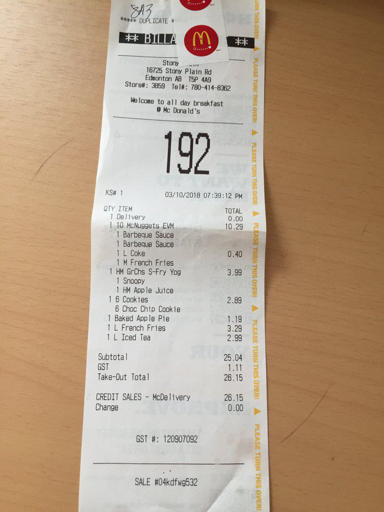

---

**`Source Node 2/2`**

**Document ID:** a2cff177-49d5-4915-900e-8ea288cd0a2c<br>**Similarity:** 0.7859198814262571<br>**Text:** file_name: ../geektime-ai-course/data/receipts/1056-receipt.jpg

<s_menu><s_nm> ZOCA RESTAURANT</...<br>**Image:**

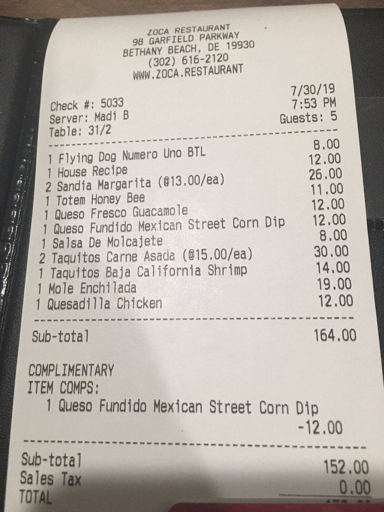

{'1ff7286d-69b6-4e1e-a0ee-a2d43cd44b88': {'file_name': '../geektime-ai-course/data/receipts/1100-receipt.jpg'},
 'a2cff177-49d5-4915-900e-8ea288cd0a2c': {'file_name': '../geektime-ai-course/data/receipts/1056-receipt.jpg'}}

In [20]:

receipts_index = GPTVectorStoreIndex.from_documents(receipt_documents)

query_engine = receipts_index.as_query_engine(query_transform=ImageOutputQueryTransform(width=400))

# receipts_response = query_engine.query(
#     'When was the last time I went to McDonald\'s and how much did I spend. \
#     Also show me the receipt from my visit.'
# )
# fix McDonald to MdDonald?
receipts_response = query_engine.query(
    'When was the last time I went to MdDonald\'s and how much did I spend. \
    Also show me the receipt from my visit.'
)

display_response(receipts_response)


In [19]:

output_image = image_parser.parse_file('../geektime-ai-course/data/receipts/1100-receipt.jpg')
print(output_image.text)

<s_menu><s_nm> Story</s_nm><s_num> 16725 Stony Platin Rd</s_nm><s_num> Store#:</s_nm><s_num> 3659</s_num><s_price> 700-418-8362</s_price><sep/><s_nm> Welcome to all day breakfast dormist O Md Donald's</s_nm><s_num> 192</s_num><s_price> 192</s_price><sep/><s_nm> QTY ITEM</s_nm><s_num> OTAL</s_num><s_unitprice> 03/10/2018</s_unitprice><s_cnt> 1</s_cnt><s_price> 07:39:12 PM</s_price><sep/><s_nm> Delivery</s_nm><s_cnt> 1</s_cnt><s_price> 0.00</s_price><sep/><s_nm> 10 McNuggets EVM</s_nm><s_cnt> 1</s_cnt><s_price> 10.29</s_price><sep/><s_nm> Barbeque Sauce</s_nm><s_cnt> 1</s_cnt><s_price> 1</s_price><sep/><s_nm> Barbeque Sauce</s_nm><s_num> 1</s_cnt><s_price> 0.40</s_price><sep/><s_nm> L Coke</s_nm><s_cnt> 1</s_cnt><s_price> 0.40</s_price><sep/><s_nm> M French Fries</s_nm><s_cnt> 1</s_cnt><s_price> 3.99</s_price><sep/><s_nm> HM GrChS S-Fry Yog</s_nm><s_cnt> 1</s_cnt><sep/><s_nm> Smoonya</s_nm><s_cnt> 1</s_cnt><sep/><s_nm> HM Apple Juice</s_nm><s_cnt> 1</s_cnt><s_price> 2.89</s_price><sep/><

# 小结

llama-index 其实给出了一种使用大语言模型的设计模式，我称之为“第二大脑”模式。通过先将外部的资料库索引，然后每次提问的时候，先从资料库里通过搜索找到有相关性的资料，然后再通过 AI 的语义理解能力让 AI 基于搜索到的结果来回答问题。

![e4ae3fbeaa82d82e317dfcef40679f6c.webp](image/e4ae3fbeaa82d82e317dfcef40679f6c.webp)